In [1]:
import pandas as pd
import numpy as np
import datetime
import pytz

from MakeSens import MakeSens
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rc('text',usetex=True)
plt.rc('font',size=16)

In [2]:
# Rango de fecha
fechaFin = datetime.datetime.now(pytz.timezone('America/Bogota')).strftime('%Y-%m-%d %H:%M:%S') # Fecha y hora Colombia
#fechaInicio = fechaFin[:-8]+f'{int(fechaFin[-8:-6])-1:02}'+fechaFin[-6:] # Restar una hora

past_date =  datetime.datetime.now(pytz.timezone('America/Bogota'))- datetime.timedelta(hours=24)  #Restar 6 días
fechaInicio = past_date.strftime('%Y-%m-%d %H:%M:%S')

Estaciones = [('E2_00023','Grupo Halley',7.1393716,-73.1210968),
            ('mE1_00004','Col. Tecnologico',7.1381572,-73.1180935),
            ('mE1_00005','Col. Santander',7.1385332,-73.121327),
            ('mE1_00007','Col. Normal',7.1277056,-73.116534),
            ('mE1_00006','Col. Pilar',7.108717813305484, -73.12173474310134),
            ('mE1_00008','Col. FundeUis',7.05756, -73.0912)]

frecuencia = "m"

#Descargamos los datos de MakeSens

In [3]:
wd = 30
ped = int(wd*0.1) 

def hour_mean(est):
    global pm25
    data = MakeSens.download_data(est, fechaInicio, fechaFin, frecuencia)
    
    if not data.empty:
        pm25 = data[["pm25_1", "pm25_2"]].copy(deep=True)
        pm25.index = pd.to_datetime(pm25.index) #Convertimos el indice a formato fecha
        
        pm25.pm25_1 = pm25.pm25_1.where(pm25.pm25_1 < 120, np.nan)
        pm25.pm25_2 = pm25.pm25_2.where(pm25.pm25_2 < 120, np.nan)
        
        pm25['pm25_1_r'] = pm25['pm25_1'].rolling(window=wd, min_periods=ped).mean() 
        pm25['pm25_2_r'] = pm25['pm25_2'].rolling(window = wd,min_periods=ped).mean()
        
        pm25['hour'] = pm25.index.hour
        
        hourly_1 = pm25.pm25_1_r.groupby(pm25.hour).mean()
        hourly_2 = pm25.pm25_2_r.groupby(pm25.hour).mean()
        
        data_final = ((hourly_1+hourly_2)/2.0).to_frame()
        
    else:
        pm25 = data
        data_final = data
    
    return data_final

In [9]:
# Introducir fechas manualmente para observar diferentes días
fechaInicio = "2023-06-28 08:00:00"
fechaFin = "2023-06-29 08:00:00"

In [5]:
df_hr = hour_mean(Estaciones[0][0])
if not df_hr.empty:
    df_hr.columns = [Estaciones[0][1]]
for est in Estaciones[1:]:
    hr = hour_mean(est[0])
    if not hr.empty:
        hr.columns = [est[1]]
    df_hr = pd.concat([df_hr,hr],axis=1)
df_hr = df_hr.transpose()
df_hr.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Grupo Halley,14.413859,11.976222,8.666778,9.256444,8.858249,7.512611,6.543220,6.176278,5.415167,5.125611,...,10.598333,15.309354,13.312093,10.753278,10.977222,13.239500,16.606222,15.722667,17.923944,13.664503
Col. Tecnologico,8.119032,7.868684,6.906818,5.881250,6.240000,5.960145,5.008333,4.441975,3.954023,3.441026,...,3.337037,6.178070,8.951333,7.134524,6.623214,6.494667,7.586420,8.643939,9.389855,10.262963
Col. Normal,10.358897,9.664976,8.054598,9.631609,9.259877,7.379444,5.647126,4.836111,3.664103,4.470000,...,8.103704,15.252778,12.460119,8.941071,7.978571,9.196667,10.997619,10.785632,14.803333,13.808333
Col. Pilar,8.691365,8.393889,7.545556,6.650575,7.809444,6.352011,7.083372,9.905747,14.226667,22.912222,...,12.967222,10.281034,7.611667,6.897222,6.493333,5.887931,7.557778,15.323889,10.273333,8.782759
Col. FundeUis,6.877213,6.678161,6.704444,6.578736,7.169444,5.256548,4.240230,5.012644,7.361111,7.884483,...,12.662222,15.950595,10.521264,10.699444,7.955747,5.423333,6.997701,8.781034,11.835057,10.535057


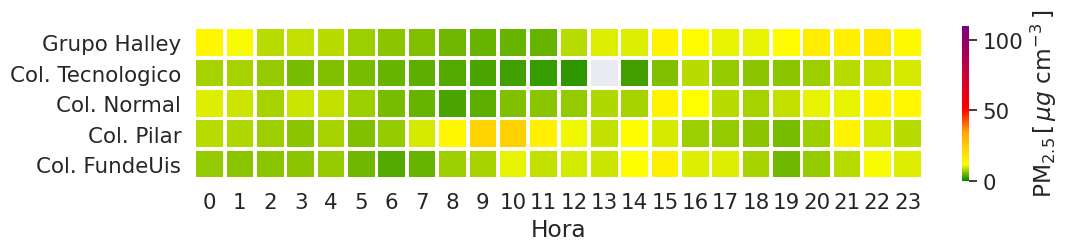

In [6]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#cvals  = [6,12,37, 55, 100]
cvals  = [0,13, 38, 56, 120]
#colors = ['green', "#c8ff00", 'yellow', 'orange', "red"]
colors = ['green',  'yellow', 'orange', "red", "purple"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list('name', tuples)
#cmap = ListedColormap(colors)

sns.set(font_scale=1.4)

plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
sns.heatmap(df_hr,cmap=cmap,square=True, linewidths=2, vmin=0, vmax=110,
           cbar_kws={'fraction' : 0.01, 'label': '$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$'})

plt.yticks(rotation=0) 
plt.xlabel('Hora')
plt.show()